# try to implement  
## "Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks"

In [2]:
!nvidia-smi | head -n 31

Mon Apr  2 17:46:57 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   64C    P0   101W / 149W |  10972MiB / 11439MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   55C    P0   120W / 149W |  10972MiB / 11439MiB |     40%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:

SAMPLE_RATE = 16000
WINDOW_SIZE = .02
WINDOW_STRIDE = .01
WINDOW = 'hamming'

HIDDEN_LAYERS = 5
#RNN_TYPE = supported_rnns['gru']
BIDIRECTIONAL = True

BEGINING_LEARNING_RATE = 3e-4
MOMENTUM = 0.9
MAX_NORM = 3
#LABELS = ''.join(data_utils.LABELS)
BATCH_SIZE = 16


GPU_CORES = [2]
RNN_SIZE = 400#768
MODEL_NAME = "test-char"
#audio_conf = dict(sample_rate=SAMPLE_RATE,
#                  window_size=WINDOW_SIZE,
#                  window_stride=WINDOW_STRIDE,
#                  window=WINDOW,
#                )

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in GPU_CORES])

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common/')
import data_utils
import utils
from utils import Dataset,ProgressBar
import tflearn
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
#from model import DeepSpeech,supported_rnns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
#import sugartensor as tf
import re
import time

In [6]:
np.zeros([3,2]).size

6

## The implemention of pytorch's DataLoader is not competiable with tflearn's DataFlow
```python
train_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_train_manifest_fix.csv')
    ,batch_size=16,shuffle=True)

test_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_test_manifest_fix.csv')
    ,batch_size=16,shuffle=True)
```

In [7]:
import pickle
with open('../data/dics.pkl','rb') as fhdl:
    ch2ind,ind2ch = pickle.load(fhdl)

In [8]:
import flow_tools

# CONFIG

In [9]:
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='./data/ted_train_manifest_fix.csv')
#voice_flow_train = data_utils.get_flow(voice_dataset_train,shuffle=True,batch_size=BATCH_SIZE)
#
#voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='./data/ted_test_manifest_fix.csv')
#voice_flow_test = data_utils.get_flow(voice_dataset_test,shuffle=False,batch_size=BATCH_SIZE)

voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_train = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=False)

voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='../data/csvs/dev_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_test = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=False)

In [10]:
voice_flow_train_shu = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=True)
voice_flow_test_shu = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=True)

shuffle
shuffle


In [11]:
import sys

In [12]:
len(voice_dataset_train),len(voice_dataset_test)

(119338, 14326)

In [13]:
from utils import Dataset

In [14]:
a,b,c,d,e = voice_flow_train.next_batch(BATCH_SIZE)

In [15]:
[ind2ch[i] for i in b[0]]

['娱', '乐', '频', '道']

In [16]:
a.shape

(16, 161, 155, 1)

你有苹果吗


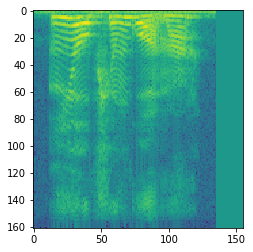

In [17]:
index = 3
#plt.figure(figsize=(30,50))
plt.imshow(a[index,:,:,0])
#plt.title(''.join(ind2ch[i] for i in b[index]))
print(''.join(ind2ch[i] for i in b[index]))
#print(c[index])
#print(d[index])
#print(e[index])

In [18]:
import IPython.display as ipd

In [19]:
print(open(d[index],encoding='utf-8').read())
ipd.Audio(c[index])

你有苹果吗


# convert data to numpy format

In [20]:
#转化一个序列列表为稀疏矩阵    
def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []
    
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
 
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    
    
    return indices, values, shape

In [21]:
tf.__version__

'1.4.0'

In [22]:
def conv_layer(input_tensor,training,kernel_size=(3,3),filters=32,dropout=None
               ,clip_net=20.,batch_normalization=True,strides=(1,1,1,1),name="conv_layer"):
    with tf.variable_scope(name):
        net = tf.layers.conv2d(input_tensor,filters=filters,kernel_size=kernel_size,padding='same',strides=strides)
        if batch_normalization:
            net = tf.layers.batch_normalization(net,training=training)
        if dropout is not None:
            net = tf.layers.dropout(net,dropout=1.-dropout)
        net = tf.nn.relu(net)
    with tf.variable_scope("minimal"):
        if clip_net is not None and clip_net != False and clip_net > 0:
            net = tf.minimum(net,tf.Variable(clip_net))
    return net

def rnn_layer(input_tensor,layer_num,rnn_seq_lens,rnn_size,training,name="rnn_layer"):
    """
        input should be like [batch_size,time,freq * filters]
    """
    with tf.variable_scope(name):
        net = input_tensor
        for i in range(layer_num):
            with tf.variable_scope("{}_layer{}".format(name,i + 1)):
                forward_cell = tf.contrib.rnn.GRUCell(rnn_size)
                backward_cell = tf.contrib.rnn.GRUCell(rnn_size)
            #bi_outputs, bi_encoder_state,_ = tf.contrib.rnn.static_bidirectional_rnn(
            #        forward_cell,backward_cell,tf.unstack(net,net_shape[1],1),dtype=tf.float32)

                bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                            forward_cell, backward_cell, net,
                            sequence_length = rnn_seq_lens,time_major = False,dtype=tf.float32)
                outputs_fw, outputs_bw = bi_outputs
                rnn_outputs = outputs_fw + outputs_bw
                rnn_outputs = tf.layers.batch_normalization(rnn_outputs, training=training)
                net = rnn_outputs
        return net
    

def _activation_summary(act,tensor_name):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measure the sparsity of activations.
    Args:
      act: Tensor
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tf.summary.histogram(tensor_name + '/activations', act)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(act))
    
def _image_summary(img,tensor_name):
    tf.summary.image(tensor_name,img)

In [23]:
list(range(2,3))

[2]

In [24]:
GPU_CORES

[2]

In [25]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.


    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [26]:
list(enumerate(GPU_CORES))

[(0, 2)]

In [27]:
assert(len(GPU_CORES) <= 4)
gpu_num = len(GPU_CORES)
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    initializer = tf.truncated_normal_initializer(
        mean=0.0,stddev=0.02)
    tf.get_variable_scope().set_initializer(initializer)
    
    if gpu_num >= 1:
        input_sound1 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets1 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 2:
        input_sound2 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets2 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 3:
        input_sound3 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets3 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 4:
        input_sound4 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets4 = tf.sparse_placeholder(tf.int32)
    # [batch_size,freq,time,1]

    voicelength = tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    global_step = tf.train.get_or_create_global_step()
    max_grad = tf.placeholder(tf.float32)
    
    #, shape=np.array([BATCH_SIZE,4], dtype=np.int64))

    learning_rate = tf.placeholder(tf.float32)
    training=tf.placeholder(tf.bool)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer_sgd = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    tower_gradients = []
    tower_gradients_sgd = []

with graph.as_default():
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for ind,one_core in enumerate(GPU_CORES):
            print(ind)
            with tf.device("/gpu:{}".format(one_core)):
                if ind == 0:
                    targets = targets1
                    input_sound = input_sound1
                elif ind == 1:
                    targets = targets2
                    input_sound = input_sound2
                elif ind == 2:
                    targets = targets3
                    input_sound = input_sound3
                elif ind == 3:
                    targets = targets4
                    input_sound = input_sound4

                conv1 = conv_layer(input_sound,training,kernel_size=(41,11),filters=32,strides=(2,2),name="deepspeech_conv_layer1")
                conv2 = conv_layer(conv1,training,kernel_size=(21,11),filters=32,strides=(2,1),name="deepspeech_conv_layer2")
                conv3 = conv_layer(conv2,training,kernel_size=(21,11),filters=96,strides=(2,1),name="deepspeech_conv_layer3")# filters=96 according to paper


                net = conv3
                net = tf.transpose(net,[0,2,1,3])
                net_shape = net.get_shape().as_list()
                net = tf.reshape(net,[BATCH_SIZE,-1,net_shape[-1] * net_shape[-2]])
                # [batch_size,time,freq * filters]
                rnn_out = rnn_layer(net,HIDDEN_LAYERS,voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],RNN_SIZE,training=training,name="deepspeech_rnn_layer")
                _activation_summary(rnn_out,'rnn_output')
                net_result = tf.layers.dense(rnn_out,len(ind2ch) + 2,activation=None,name="deepspeech_dense")
                _activation_summary(net_result,'net_result')

                with tf.variable_scope("Loss"):
                    ctc_loss = tf.nn.ctc_loss(labels=targets,inputs=net_result,sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE]
                                              ,time_major=False)
                    loss = tf.reduce_mean(ctc_loss)
                    tf.summary.scalar("Loss",loss)

                with tf.variable_scope("LearningRate"):
                    tf.summary.scalar("LearningRate",learning_rate)


                decoded, log_prob = tf.nn.ctc_beam_search_decoder(tf.transpose(net_result, (1, 0, 2)),
                                                                  sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],merge_repeated=False)
                dense_decoded = tf.cast(tf.sparse_tensor_to_dense(decoded[0], default_value=0), tf.int32)

                with tf.variable_scope("EditDistance"):
                    dis = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
                    tf.summary.scalar("EditDistance",dis)

                trainable_params = tf.trainable_variables()
                trainable_params = [i for i in trainable_params if
                                    ('deepspeech' in i.name and 'Minimum_grad' not in i.name)]
                #grads_e = optimizer.compute_gradients(ctc_loss, var_list = trainable_params)
                #grads_e_sgd = optimizer_sgd.compute_gradients(ctc_loss, var_list = trainable_params)
                #gradients = tf.gradients(ctc_loss, trainable_params)
                #clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
                #clip_gradients_sgd, _ = tf.clip_by_global_norm(gradients, max_grad)
                #L_loss = tf.clip_by_value(loss, -max_grad, max_grad)
                L_loss = loss
                tf.get_variable_scope().reuse_variables()
                #train_op = optimizer.minimize(loss,global_step=global_step)
                #train_op = optimizer.apply_gradients(
                #        zip(clip_gradients, trainable_params), global_step=global_step)
                grads_e_ori = optimizer.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_ori = [i[0] for i in grads_e_ori]
                grads_e, _ = tf.clip_by_global_norm(grads_e_ori, max_grad)
                #grads_e = grads_e_ori
                grads_e_sgd_ori = optimizer_sgd.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_sgd_ori = [i[0] for i in grads_e_sgd_ori]
                grads_e_sgd, _ = tf.clip_by_global_norm(grads_e_sgd_ori, max_grad)
                #grads_e_sgd = grads_e_sgd_ori
                tower_gradients.append(zip(grads_e,trainable_params))
                tower_gradients_sgd.append(zip(grads_e_sgd,trainable_params))
                print('finish {}'.format(ind))


with graph.as_default():
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
    grads = average_gradients(tower_gradients)
    grads_sgd = average_gradients(tower_gradients_sgd)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(grads,global_step)
        train_op_sgd = optimizer_sgd.apply_gradients(grads_sgd,global_step)
    with tf.variable_scope("Validation"):
        test_loss = tf.placeholder(tf.float32)
        loss_op = tf.summary.scalar("Accuracy",test_loss)
        editdistance = tf.placeholder(tf.float32)
        editdistance_op = tf.summary.scalar("EditDistance",editdistance)
    test_op = tf.summary.merge([loss_op,editdistance_op])


0
finish 0


In [28]:
grads_e[:2]

[<tf.Tensor 'clip_by_global_norm/clip_by_global_norm/_0:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'clip_by_global_norm/clip_by_global_norm/_1:0' shape=<unknown> dtype=float32>]

In [29]:
grads_e_ori[:2]

[<tf.Tensor 'gradients/deepspeech_conv_layer1/conv2d/Conv2D_grad/tuple/control_dependency_1:0' shape=(41, 11, 1, 32) dtype=float32>,
 <tf.Tensor 'gradients/deepspeech_conv_layer1/conv2d/BiasAdd_grad/tuple/control_dependency_1:0' shape=(32,) dtype=float32>]

In [30]:
net_result.shape,net.shape,ctc_loss.shape,net.shape,net_shape

(TensorShape([Dimension(16), Dimension(None), Dimension(4232)]),
 TensorShape([Dimension(16), Dimension(None), Dimension(2016)]),
 TensorShape([Dimension(16)]),
 TensorShape([Dimension(16), Dimension(None), Dimension(2016)]),
 [16, None, 21, 96])

In [31]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    
    sess.run(tf.global_variables_initializer())
    tf.train.global_step(sess, global_step)

In [31]:
import os
if not os.path.exists("models/{}".format(MODEL_NAME)):
    os.mkdir("models/{}".format(MODEL_NAME))

In [32]:
import os
allmodels = [i  for i in os.listdir('models/{}'.format(MODEL_NAME)) if ('meta' in i and 'model' in i)]

In [33]:
epochs = [int(i[-6]) for i in allmodels]

In [34]:
if epochs:
    train_epoch = max(epochs) + 1
else:
    train_epoch = 1
train_batch = 1

In [35]:
train_epoch

1

In [32]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,'./models/1_24-char/model_10')

INFO:tensorflow:Restoring parameters from ./models/1_24-char/model_10


In [33]:
! ls -l ./models/1_24-char/model_10*

-rw-rw-r-- 1 mtq mtq 258457640 Feb 25 21:02 ./models/1_24-char/model_10.data-00000-of-00001
-rw-rw-r-- 1 mtq mtq     11190 Feb 25 21:02 ./models/1_24-char/model_10.index
-rw-rw-r-- 1 mtq mtq  12359506 Feb 25 21:02 ./models/1_24-char/model_10.meta


In [34]:
MODEL_NAME

'test-char'

In [35]:
N_BATCH = len(voice_dataset_train) // (BATCH_SIZE * gpu_num)
N_BATCH_TEST = len(voice_dataset_test) // (BATCH_SIZE * gpu_num)

In [36]:
batch_x,batch_y_ori,s,a,t = voice_flow_test_shu.next_batch(BATCH_SIZE)
batch_seq_len  = [i // 2 for i in t]
feeddic={
    voicelength:batch_seq_len,
    training:False,
    input_sound1:batch_x,
}

In [41]:
batch_x.shape

(16, 161, 261, 1)

In [37]:
batch_translate = sess.run(dense_decoded,feed_dict=feeddic)

In [42]:
for i,j,audio in zip(batch_y_ori,batch_translate,s):
    ipd.display(ipd.Audio(audio))
    print("target:{}\npredict:{}\n".format(
            ''.join(list(ind2ch[x] for x in i)),
            (''.join(list(ind2ch[x] for x in j)).strip('的'))
        ))

target:剃光头吧
predict:提供头伴



target:感叹时光匆匆
predict:但看时光丰松



target:我没家没小孩
predict:我们家没小孩



target:再度备受关注
predict:再度备手关注



target:十多人受伤
predict:石多人受伤



target:成为了幸运儿
predict:成为了幸玥儿



target:而近年的蓝洁瑛
predict:而今年的短节影



target:整个人焕然一新
predict:整个人换着一些



target:大家神情放松
predict:大家申请放松



target:获观众的心
predict:吕获观众的心



target:目前已有一人死亡
predict:目前已有一人死亡



target:超过减排的目标
predict:超过减牌的目标



target:姿色不逊母亲
predict:自色不迅母亲



target:致一只耳朵裂成两半
predict:这一这着连成两本



target:背心还内置救生拉环
predict:被京还内着就成拉环



target:他确实发挥得非常好
predict:它却释放运的非常好

